In [1]:
from PINN.pinn_solver_mimo import PINNSolver
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
import time
import pandas as pd

from PIL import Image


# For LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tqdm.keras import TqdmCallback


DTYPE = 'float32'


class SPINN(PINNSolver):
    def __init__(self, x_r, u_r, y_r, s1, s2, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.K11 = 2.0
        self.K12 = 0
        self.K21 = 0
        self.K22 = 1.0
        self.tau11 = 5.0
        self.tau12 = 5.0 
        self.tau21 = 5.0
        self.tau22 = 5.0
        self.x_r = x_r
        self.u = u_r
        self.y_r = y_r
        self.s1 = s1
        self.s2 = s2
        self.dt = 1
        self.files = []
        
    @tf.function
    def get_residual_loss(self):
 
        y = self.model(self.x_r)
            
        return self.residual_function(self.u, y)

    def residual_function(self, u, y_nn):
        """Residual of the ODE"""
        y = (y_nn - self.s2.min_) * 1/self.s2.scale_ + self.s2.data_min_

        y_t = (y[1:]-y[:-1]) / self.dt
        yn = y[0:-1]
        un = u[0:-1]
        
        res1 = self.tau11 * y_t[:,:,0] + yn[:,:,0] - self.K11 * un[:,:,0]
        res2 = self.tau22 * y_t[:,:,1] + yn[:,:,1] - self.K22 * un[:,:,1]

        return 1*res1, 1*res2

    def callback(self, *args):
        
        path = "figures_for_gif/"

        if self.iter % 10 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter, self.current_loss)
                  )
        
        # making animation
#         y_meas = self.y_r # Data Range for Animation
#         y_nn = self.model(self.x_r)
#         y_meas = self.s2.inverse_transform(y_meas)
#         y_nn = self.s2.inverse_transform(y_nn)


#         plt.figure(0, figsize=(12,3))
# #         plt.subplot(2,1,1)
#         plt.plot(y_nn,'r-',label='LSTM')
#         plt.plot(y_meas,'b--',label='Measured')
#         plt.ylim([0,3.5])
#         plt.xlim([0,len(y_nn)])
#         plt.title('LSTM-Onestep model Validation',fontsize=15)
#         plt.ylabel("T1", fontsize=13)
#         plt.legend(loc=4,fontsize=13)
#         plt.text(10,2.5,"Training step: %i"%(self.iter+1),fontsize="xx-large",color="k")
#         plt.savefig(path + "animation{}.png".format(self.iter), bbox_inches='tight', transparent=True, pad_inches=0.1, dpi=100, facecolor="white")
#         plt.clf()
#         plt.close()

#         self.files.append(path + "animation{}.png".format(self.iter))
            
        self.hist.append(self.current_loss)
        self.iter += 1


In [2]:
# for creating animation
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [3]:
# Load Data
data1_us = pd.read_pickle('open_loop_data_MIMO_narrow.pkl') # for LOSS 1 (NN Training)
data2_us = pd.read_pickle('open_loop_data_MIMO_wide.pkl') # for Loss 2 (PINN) 

data1_us = np.transpose(data1_us)
data2_us = np.transpose(data2_us)

# data2 = data2[0:1500]

data1_us=pd.DataFrame(data1_us) # "_us" means unshifted. y needs to be shifted one timestep forward
data1_us.columns=['u1','u2','y1','y2']
data1 = data1_us
data1['y1'][1:] = data1_us['y1'][0:-1] # y shifted
data1['y2'][1:] = data1_us['y2'][0:-1]


data2_us = pd.DataFrame(data2_us)
data2_us.columns=['u1','u2','y1','y2']
data2 = data2_us
data2['y1'][1:] = data2_us['y1'][0:-1] # y shifted
data2['y2'][1:] = data2_us['y2'][0:-1]
data2['y1'][0:20] = 0 # y shifted
data2['y2'][0:20] = 0



data3 = pd.concat([data1, data2], ignore_index=True) # for validation 

In [4]:
path ="figs_result/"

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


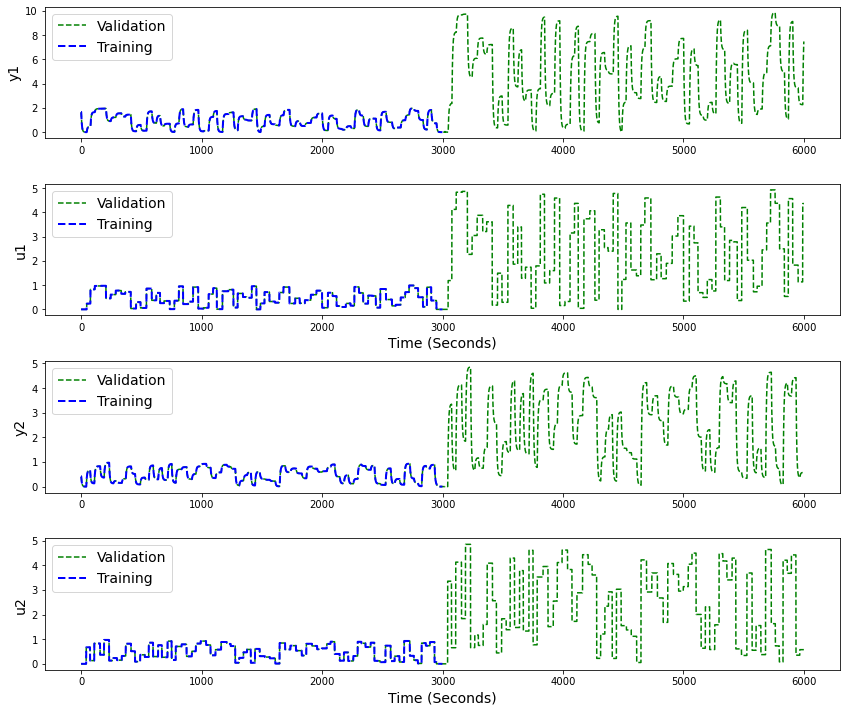

In [30]:
plt.figure(figsize=(12,10))
plt.subplot(411)
plt.plot(data3["y1"], 'g--',  label='Validation')
plt.plot(data1["y1"], 'b--', linewidth=2, label='Training')
plt.ylabel("y1",fontsize=14)
plt.legend(fontsize=14)

plt.subplot(412)
plt.plot(data3["u1"], 'g--',label='Validation')
plt.plot(data1["u1"], 'b--',linewidth=2,label='Training')
plt.ylabel("u1",fontsize=14)
plt.xlabel("Time (Seconds)", fontsize=14)
plt.legend(fontsize=14)

plt.subplot(413)
plt.plot(data3["y2"], 'g--',  label='Validation')
plt.plot(data1["y2"], 'b--', linewidth=2, label='Training')
plt.ylabel("y2",fontsize=14)
plt.legend(fontsize=14)

plt.subplot(414)
plt.plot(data3["u2"], 'g--',label='Validation')
plt.plot(data1["u2"], 'b--',linewidth=2,label='Training')
plt.ylabel("u2",fontsize=14)
plt.xlabel("Time (Seconds)", fontsize=14)
plt.legend(fontsize=14)

plt.tight_layout()

plt.savefig(path + 'FOPDT_Data_for_PINN_training_MIMO.eps', format='eps')
plt.savefig(path + 'FOPDT_Data_for_PINN_training_MIMO.png', format='png')

plt.show()


In [6]:
# Data scaling

# Scale features
s1 = MinMaxScaler(feature_range=(-1,1), copy=False)
s1.data_max_ = np.array([6,6,6,6])
s1.data_min_ = np.array([0,0,0,0])
s1.min_ = np.array([-1,-1,-1,-1])
s1.max_ = np.array([1,1,1,1])
s1.data_range_ = np.array([6,6,6,6])
s1.scale_ = np.array([2/6,2/6,2/6,2/6])

s2 = MinMaxScaler(feature_range=(-1,1), copy=False)
s2.data_max_ = np.array([6,6])
s2.data_min_ = np.array([0,0])
s2.data_range_ = np.array([6,6])
s2.min_ = np.array([-1,-1])
s2.max_ = np.array([1,1])
s2.scale_ = np.array([2/6, 2/6])

# Execute scaling
Xs1 = s1.transform(data1[['u1','u2','y1','y2']].to_numpy())
Ys1 = s2.transform(data1[['y1','y2']].to_numpy())

Xs2 = s1.transform(data3[['u1','u2','y1','y2']].to_numpy())
Ys2 = s2.transform(data3[['y1','y2']].to_numpy())

window = 5
P = 20

# Save model parameters
model_params = dict()
model_params['Xscale'] = s1
model_params['yscale'] = s2
model_params['window'] = window

dump(model_params, open('model_param_mimo.pkl', 'wb'))

In [7]:
# Data Snap shots for training data

X_train = []
Y_train = []
for i in range(window,len(Xs1)-P):
    X_train.append(Xs1[i-window:i+P,:])
    Y_train.append(Ys1[i:i+P])


# Reshape data to format accepted by LSTM
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [8]:
# Data Snap shots for validation data
X_val = []
Y_val = []
for i in range(window,len(Xs2)-P):
    X_val.append(Xs2[i-window:i+P,:])
    Y_val.append(Ys2[i:i+P])

# Reshape data to format accepted by LSTM
X_val, Y_val = np.array(X_val), np.array(Y_val)

In [9]:
for i in range(0, len(X_train)):
    X_train[i][window:,2] = X_train[i][window-1,2]
    X_train[i][window:,3] = X_train[i][window-1,3]

for i in range(0, len(X_val)):
    X_val[i][window:,2] = X_val[i][window-1,2]
    X_val[i][window:,3] = X_val[i][window-1,3]

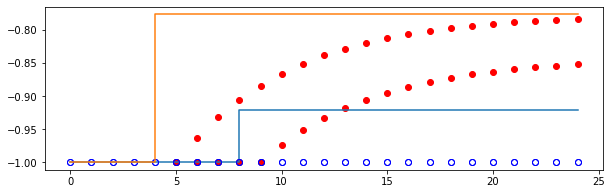

In [10]:
i = 38
plt.figure(figsize=(10,3))
t = np.linspace(0, 24, 25)
plt.plot(t[5:],Y_train[i],'ro')
plt.plot(t, X_train[i][:,2],'bo', mfc='none')
plt.step(t, X_train[i][:,0])
plt.plot(t, X_train[i][:,3],'bo', mfc='none')
plt.step(t, X_train[i][:,1])

In [11]:
n_feature = X_train.shape[2]
n_label = Y_train.shape[1]

encoder_input = tf.keras.layers.Input(shape=(window+P, n_feature))
xl = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(encoder_input,encoder_input)
res = xl + encoder_input
xl = tf.keras.layers.Dense(100, 'tanh')(res)
xl = tf.keras.layers.Dropout(0.2)(xl)
xl = tf.keras.layers.Dense(n_feature, None)(xl)

xl = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(xl,xl)
res = xl + encoder_input
xl = tf.keras.layers.Dense(100, 'tanh')(res)
xl = tf.keras.layers.Dropout(0.2)(xl)
xl = tf.keras.layers.Dense(n_feature, None)(xl)

xl = tf.keras.layers.Flatten()(xl)
xl = tf.keras.layers.Dense(units=Y_train.shape[1]*Y_train.shape[2], activation=None)(xl)
yl = tf.keras.layers.Reshape((Y_train.shape[1], Y_train.shape[2]))(xl)

model_trans1 = tf.keras.Model(inputs=encoder_input, outputs=yl, name="mhl")

model_trans2 = tf.keras.models.clone_model(model_trans1)

# model_trans2 = tf.keras.Model(inputs=encoder_input, outputs=yl, name="mhl")

# model_trans.compile(optimizer='Adam',loss='MSE',metrics='accuracy')

# Allow for early exit
# es_trans = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

# t0 = time.time()
# result_trans = model_trans.fit(X_train,Y_train,epochs=300,batch_size=32, \
#                                callbacks=[es_trans, TqdmCallback(verbose=1)], \
#                                verbose=0, validation_data=(X_val, Y_val))
# t1 = time.time()

# print('Runtime: %.2f s' %(t1-t0))

# model_trans.summary()

Metal device set to: Apple M1 Pro


2022-06-05 09:40:40.560025: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-05 09:40:40.560167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
# input data ("u") for loss2 (pinn)
x_r = X_val # Scaled Snapshot of X to evaluating NN model

# u_r = data3[["u1","u2"]].to_numpy()[window:Xs2.shape[0]-10] # Original u data evaluating residual
x_val = (X_val - s1.min_) * 1/s1.scale_ + s1.data_min_ 
u_r = x_val[:,window:,:2]
u_r = tf.convert_to_tensor(u_r, DTYPE)

y_r = Y_val # Scaled Snapshot of Y

solver1 = SPINN(model=model_trans1, x_r=x_r,u_r=u_r, y_r=y_r, s1=s1, s2=s2, is_pinn=False)
solver2 = SPINN(model=model_trans2, x_r=x_r,u_r=u_r, y_r=y_r, s1=s1, s2=s2, is_pinn=True)
# # Choose step sizes aka learning rate
# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 5000], [1e-3, 1e-4, 1e-5])

# Solve with Adam optimizer
optim = tf.keras.optimizers.Adam()

X_train = tf.convert_to_tensor(X_train, DTYPE)
Y_train = tf.convert_to_tensor(Y_train, DTYPE)

In [13]:
# PINN Off case
solver1.is_pinn = False
solver1.solve_with_tf_optimizer(optim, X_train, Y_train, n_step=500)

2022-06-05 09:40:41.066480: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-05 09:40:41.066568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


It 00000: loss = 6.88233495e-01
It 00010: loss = 3.64116669e-01
It 00020: loss = 1.12827621e-01
It 00030: loss = 3.32829654e-02
It 00040: loss = 2.29657385e-02
It 00050: loss = 1.83465332e-02
It 00060: loss = 1.61581747e-02
It 00070: loss = 1.50223905e-02
It 00080: loss = 1.44679770e-02
It 00090: loss = 1.41446944e-02
It 00100: loss = 1.39161861e-02
It 00110: loss = 1.37076806e-02
It 00120: loss = 1.35089476e-02
It 00130: loss = 1.33173047e-02
It 00140: loss = 1.31262131e-02
It 00150: loss = 1.29307397e-02
It 00160: loss = 1.27259307e-02
It 00170: loss = 1.25065167e-02
It 00180: loss = 1.22665763e-02
It 00190: loss = 1.19993277e-02
It 00200: loss = 1.16971415e-02
It 00210: loss = 1.13516226e-02
It 00220: loss = 1.09539833e-02
It 00230: loss = 1.04958266e-02
It 00240: loss = 9.97055788e-03
It 00250: loss = 9.37546231e-03
It 00260: loss = 8.71429034e-03
It 00270: loss = 7.99963903e-03
It 00280: loss = 7.25374976e-03
It 00290: loss = 6.50623068e-03
It 00300: loss = 5.78835327e-03
It 00310

In [14]:
# save_gif_PIL("pinn_off.gif", solver1.files, fps=50, loop=0)  

In [15]:
#%% Save LSTM model file
solver1.model.save('PINN_FOPDT_mimo_multistep_Trans_pinn_off.h5')

In [16]:
# #PINN On case
solver2.is_pinn = True
solver2.solve_with_tf_optimizer(optim, X_train, Y_train, n_step=2000)

solver2.solve_with_scipy_optimizer(X_train, Y_train, method='L-BFGS-B')

2022-06-05 09:42:07.944796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


It 00000: loss = 1.53823099e+01
It 00010: loss = 4.85506630e+00
It 00020: loss = 2.20002794e+00
It 00030: loss = 1.42999530e+00
It 00040: loss = 1.09353161e+00
It 00050: loss = 9.18487191e-01
It 00060: loss = 8.13795805e-01
It 00070: loss = 7.47196436e-01
It 00080: loss = 6.97442353e-01
It 00090: loss = 6.56733155e-01
It 00100: loss = 6.20867908e-01
It 00110: loss = 5.88476598e-01
It 00120: loss = 5.58660150e-01
It 00130: loss = 5.30638337e-01
It 00140: loss = 5.03787875e-01
It 00150: loss = 4.77812856e-01
It 00160: loss = 4.52631712e-01
It 00170: loss = 4.28268433e-01
It 00180: loss = 4.04783934e-01
It 00190: loss = 3.82235080e-01
It 00200: loss = 3.60659420e-01
It 00210: loss = 3.40073198e-01
It 00220: loss = 3.20475161e-01
It 00230: loss = 3.01852465e-01
It 00240: loss = 2.84185588e-01
It 00250: loss = 2.67452538e-01
It 00260: loss = 2.51630634e-01
It 00270: loss = 2.36698359e-01
It 00280: loss = 2.22635180e-01
It 00290: loss = 2.09421352e-01
It 00300: loss = 1.97036684e-01
It 00310

2022-06-05 10:10:31.062531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 10:10:31.437787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


It 02000: loss = 1.21676351e-03


      fun: 0.0011956447269767523
 hess_inv: <6616x6616 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.44784405e-06,  1.65068366e-06,  2.01974945e-06, ...,
        2.88469921e-04, -2.10947561e-04,  2.97580205e-04])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 8
      nit: 5
     njev: 8
   status: 1
  success: False
        x: array([ 0.36292167,  0.4606909 , -0.39292835, ..., -0.05933876,
       -0.01687045, -0.06146654])

In [17]:
solver2.model.save('PINN_FOPDT_mimo_multistep_Trans_pinn_on.h5')

In [18]:
# save_gif_PIL("pinn_on.gif", solver2.files, fps=50, loop=0)  

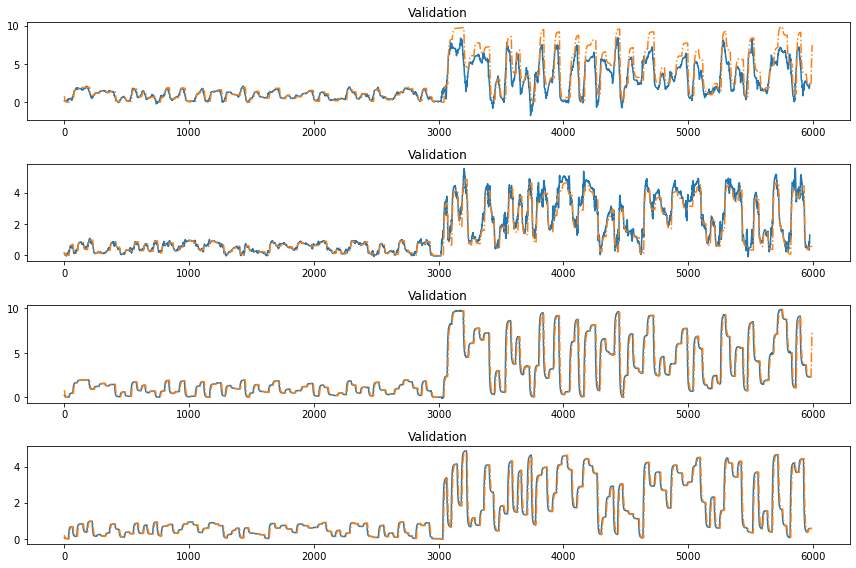

In [19]:
# Model evaluation with input datas (PINN off model)
ynn_off = solver1.model(X_val)
ynn_off = (ynn_off - s2.min_) * 1/s2.scale_ + s2.data_min_

# ynn_off = s2.inverse_transform(ynn_off)

# Model evaluation with input datas (PINN on model)
ynn_on = solver2.model(X_val)
ynn_on = (ynn_on - s2.min_) * 1/s2.scale_ + s2.data_min_
# ynn_on = s2.inverse_transform(ynn_on)

plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.gca().set_title('Validation')
plt.plot(ynn_off[:,5,0])
plt.plot(data3["y1"].to_numpy()[window:], '-.')
# plt.plot(validation["y"].to_numpy()[ynn_train_off.shape[0]+window+window:], '-.')

plt.subplot(4,1,2)
plt.gca().set_title('Validation')
plt.plot(ynn_off[:,5,1])
plt.plot(data3["y2"].to_numpy()[window:], '-.')
# plt.plot(validation["y"].to_numpy()[ynn_train_off.shape[0]+window+window:], '-.')


plt.subplot(4,1,3)
plt.gca().set_title('Validation')
plt.plot(ynn_on[:,5,0])
plt.plot(data3["y1"].to_numpy()[window:], '-.')
# plt.plot(validation["y"].to_numpy()[ynn_train_on.shape[0]+window+window:], '-.')


plt.subplot(4,1,4)
plt.gca().set_title('Validation')
plt.plot(ynn_on[:,5,1])
plt.plot(data3["y2"].to_numpy()[window:], '-.')
# plt.plot(validation["y"].to_numpy()[ynn_train_on.shape[0]+window+window:], '-.')

plt.tight_layout()
plt.show()

In [20]:
y_val = (Y_val - s2.min_) * 1/s2.scale_ + s2.data_min_

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


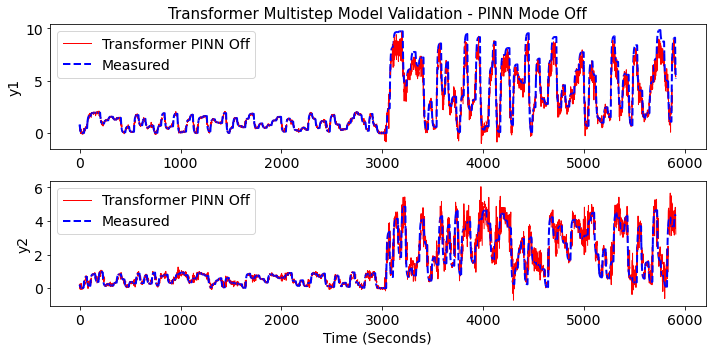

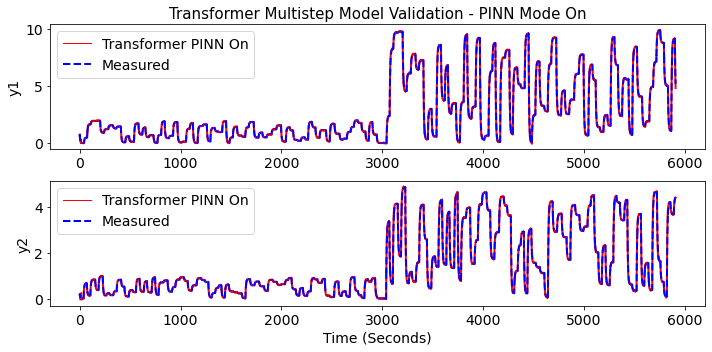

In [68]:
# Plotting for 

t=np.linspace(0,len(ynn_off)-1,len(ynn_off))

plt.figure(0,figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t[0:P], ynn_off[0][:,0], 'r-',linewidth=1, label="Transformer PINN Off")
plt.plot(t[0:P], y_val[0][:,0], 'b--', linewidth=2, label="Measured")
for i in range(0,5900,19):   
    plt.plot(t[i:i+P], ynn_off[i][:,0], 'r-',linewidth=1)
    plt.plot(t[i:i+P], y_val[i][:,0], 'b--', linewidth=2)
    
plt.title('Transformer Multistep Model Validation - PINN Mode Off',fontsize=15)
plt.ylabel("y1", fontsize=14)
plt.legend(loc=2,fontsize=14)
plt.tick_params(axis='both',labelsize=14)


plt.subplot(2,1,2)
plt.plot(t[0:P], ynn_off[0][:,1], 'r-',linewidth=1, label="Transformer PINN Off")
plt.plot(t[0:P], y_val[0][:,1], 'b--', linewidth=2, label="Measured")
for i in range(0,5900,19):   
    plt.plot(t[i:i+P], ynn_off[i][:,1], 'r-',linewidth=1)
    plt.plot(t[i:i+P], y_val[i][:,1], 'b--', linewidth=2)
    
plt.tight_layout()
plt.ylabel("y2", fontsize=14)
plt.xlabel("Time (Seconds)", fontsize=14)
plt.legend(loc=2,fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.tight_layout()

plt.savefig(path + 'FOPDT_mimo_PINN_Training_result_PINN_Off.eps', format='eps')
plt.savefig(path + 'FOPDT_mimo_PINN_Training_result_PINN_Off.png', format='png')



plt.figure(1, figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t[0:P], ynn_off[0][:,0], 'r-',linewidth=1, label="Transformer PINN On")
plt.plot(t[0:P], y_val[0][:,0], 'b--', linewidth=2, label="Measured")

for i in range(0,5900,19):   
    plt.plot(t[i:i+P], ynn_on[i][:,0], 'r-',linewidth=2)
    plt.plot(t[i:i+P], y_val[i][:,0], 'b--', linewidth=2)
    
plt.ylabel("y1", fontsize=14)
plt.legend(loc=2,fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.title('Transformer Multistep Model Validation - PINN Mode On',fontsize=15)    


plt.subplot(2,1,2)
plt.plot(t[0:P], ynn_off[0][:,1], 'r-',linewidth=1, label="Transformer PINN On")
plt.plot(t[0:P], y_val[0][:,1], 'b--', linewidth=2, label="Measured")

for i in range(0,5900,19):   
    plt.plot(t[i:i+P], ynn_on[i][:,1], 'r-',linewidth=2)
    plt.plot(t[i:i+P], y_val[i][:,1], 'b--', linewidth=2)
    

plt.ylabel("y2", fontsize=14)
plt.xlabel("Time (Seconds)", fontsize=14)
plt.legend(loc=2,fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.tight_layout() 
    
plt.savefig(path + 'FOPDT_mimo_PINN_Training_result_PINN_On.eps', format='eps')
plt.savefig(path + 'FOPDT_mimo_PINN_Training_result_PINN_On.png', format='png')
    

plt.show()


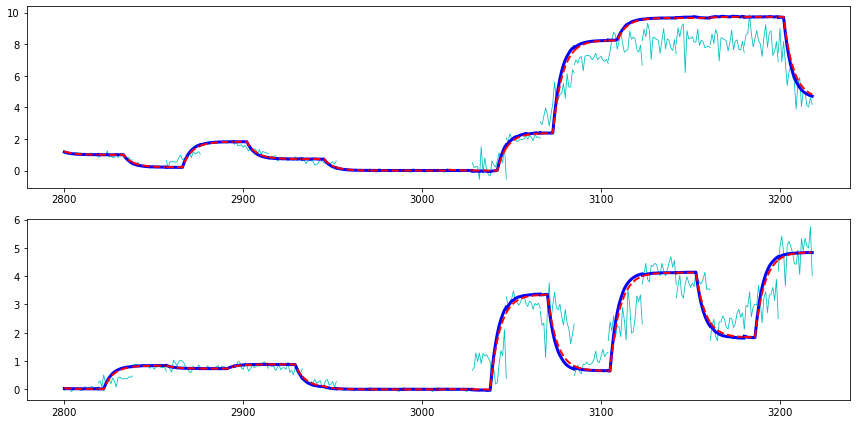

In [28]:
t=np.linspace(0,len(ynn_off)-1,len(ynn_off))

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
for i in range(2800,3200,19):   
    plt.plot(t[i:i+P], ynn_off[i][:,0], 'c-',linewidth=0.8)
    plt.plot(t[i:i+P], ynn_on[i][:,0], 'b-',linewidth=3)
    plt.plot(t[i:i+P], y_val[i][:,0], 'r--', linewidth=2)
    
plt.subplot(2,1,2)
for i in range(2800,3200,19):   
    plt.plot(t[i:i+P], ynn_off[i][:,1], 'c-',linewidth=0.8)
    plt.plot(t[i:i+P], ynn_on[i][:,1], 'b-',linewidth=3)
    plt.plot(t[i:i+P], y_val[i][:,1], 'r--', linewidth=2)
    
plt.tight_layout()
plt.show()

In [22]:
solver2.loss1, solver2.loss2, solver2.loss3 

(<tf.Tensor: shape=(), dtype=float32, numpy=5.651626e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00086596765>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00027316087>)